In [1]:
import os
import sys

import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
from typing import List
from pathlib import Path
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sys.path.append('..')
from importlib import reload
from beergenrnn import beerxml, dataset, model

In [267]:
reload(dataset)
ds = dataset.RecipeDataset()
dl = DataLoader(ds, batch_size=8, shuffle=True)

In [268]:
reload(model)
mdl = model.RecipeModel(n_fermentables=len(ds.dicts['fermentables_name']),
                       n_hops=len(ds.dicts['hops_name']),
                        n_hops_uses=len(ds.dicts['hops_use']),
                       n_yeasts=len(ds.dicts['yeasts_name']))
trainer = model.Trainer(mdl, name='lstm_scaled')
mdl

RecipeModel(
  (style_model): Sequential(
    (0): Embedding(128, 32)
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): Tanh()
  )
  (fermentables_model): Model(
    (emb): Embedding(128, 32, padding_idx=0)
    (rnn): LSTM(32, 128, batch_first=True)
    (heads): Heads(
      (fcs): ModuleList(
        (0): Sequential(
          (0): Dropout(p=0.5, inplace=False)
          (1): Linear(in_features=128, out_features=56, bias=True)
        )
        (1): Sequential(
          (0): Dropout(p=0.5, inplace=False)
          (1): Linear(in_features=128, out_features=1, bias=True)
        )
      )
    )
  )
  (hops_model): Model(
    (emb): Embedding(128, 32, padding_idx=0)
    (rnn): LSTM(32, 128, batch_first=True)
    (heads): Heads(
      (fcs): ModuleList(
        (0): Sequential(
          (0): Dropout(p=0.5, inplace=False)
          (1): Linear(in_features=128, out_features=61, bias=True)
        )
        (1): Sequential(
          (0): Dropout(p=0.5, inplace=False)
 

In [269]:
loss = trainer.fit(200, dl)

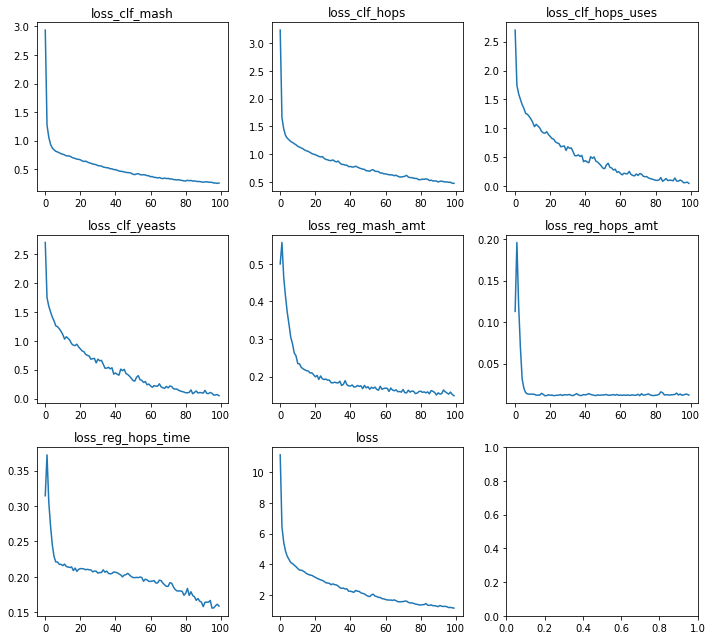

In [191]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(10,9))
for (loss_name, history), ax in zip(loss.items(), axes.flat):
    ax.plot(np.arange(len(history)), history)
    ax.set_title(loss_name)

plt.tight_layout()
plt.show()

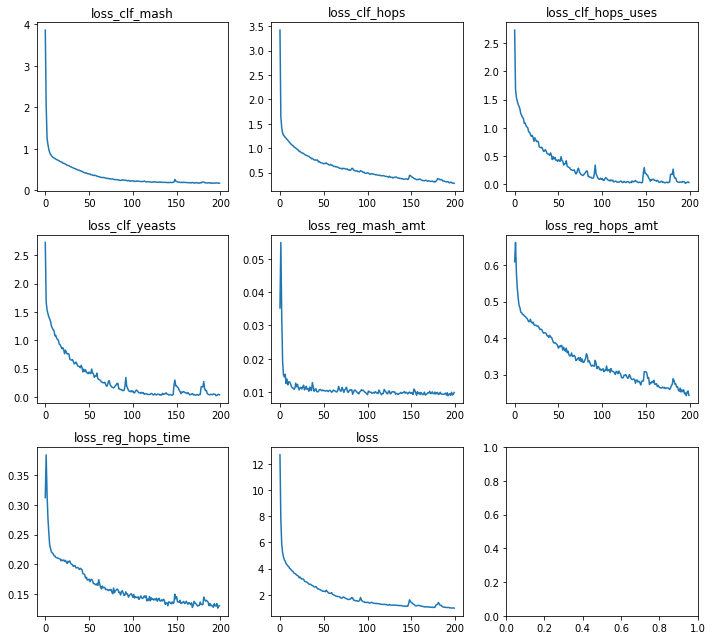

In [270]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(10,9))
for (loss_name, history), ax in zip(loss.items(), axes.flat):
    ax.plot(np.arange(len(history)), history)
    ax.set_title(loss_name)

plt.tight_layout()
plt.show()

In [134]:
mdl.load_state_dict(torch.load('../checkpoints/lstm.pth'))

<All keys matched successfully>

In [281]:
def decode_predictions(generated, dicts, style, batch_size=20):
    reversed_dicts = {n: {v: k for k, v in d.items()} for n, d in dicts.items()}
    print(f'Generate style {reversed_dicts["style_name"][style]}, batch size {batch_size} liters')
    generated = {k: [reversed_dicts[k][i] for i in v] if k in reversed_dicts else list(v) for k, v in generated.items()}
    
    generated['hops_amount'] = [round(v * batch_size) for v in generated['hops_amount']]
    generated['fermentables_amount'] = [round(v * batch_size, 2) for v in generated['fermentables_amount']]
    generated['hops_time'] = [int(v * 60) for v in generated['hops_time']]
    return generated

In [256]:
ds.dicts['style_name']

{'Altbier': 3,
 'American Ale': 4,
 'American Amber Ale': 5,
 'Barley Wine': 6,
 'Belgian Ale': 7,
 'Belgian Blonde': 8,
 'Belgian Strong Ale': 9,
 'Berliner Weisse': 10,
 'Bitter': 11,
 'Black Barley Wine': 12,
 'Black IPA': 13,
 'Black Lager': 14,
 'Blonde Imperial Stout': 15,
 'Braggot': 16,
 'Breakfast Stout': 17,
 'Brown Ale': 18,
 'Cask Ale': 19,
 'Double IPA': 20,
 'Eisbock': 21,
 'Fruit Beer': 22,
 'German Hefeweizen': 23,
 'Gose': 24,
 'IPA': 25,
 'Imperial Ale': 26,
 'Imperial Black IPA': 27,
 'Imperial Brown Ale': 28,
 'Imperial IPA': 29,
 'Imperial Pilsner': 30,
 'Imperial Porter': 31,
 'Imperial Red Ale': 32,
 'Imperial Smoked Porter': 33,
 'Imperial Stout': 34,
 'Imperial Weizenbock': 35,
 'Imperial Wheat': 36,
 'International Pale Lager': 37,
 'Irish Stout': 38,
 'KÃ¶lsch': 39,
 'Lager': 40,
 'Low Alcohol': 41,
 'Milk Stout': 42,
 'Pale Ale': 43,
 'Pilsner': 44,
 'Porter': 45,
 'Quadrupel': 46,
 'Quadruple IPA': 47,
 'Red Ale': 48,
 'Rye Ale': 49,
 'Rye IPA': 50,
 'Rye P

In [300]:
style = 60
generated = mdl.generate(style, deterministic=True)
decode_predictions(generated, ds.dicts, style)

Generate style Wheat Stout, batch size 20 liters


{'fermentables_name': ['Extra Pale Spring Blend',
  'Caramalt',
  'Crystal 150',
  'Chocolate',
  'Roasted Barley',
  'Wheat'],
 'fermentables_amount': [4.13, 1.05, 0.54, 0.48, 0.16, 0.1],
 'hops_name': ['Chinook', 'Centennial', 'Chinook'],
 'hops_amount': [18, 13, 6],
 'hops_time': [28, 10, 5],
 'hops_use': ['Boil', 'Boil', 'Boil'],
 'yeasts_name': ['Wyeast 1056 - American Ale']}

Style embeddings

In [161]:
style_emb = mdl.style_model[0].weight.detach().numpy()
style_emb.shape

(128, 32)

In [167]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [181]:
man = TSNE(n_components=2, perplexity=4)
pc = man.fit_transform(style_emb[3:61])
pc.shape

(58, 2)

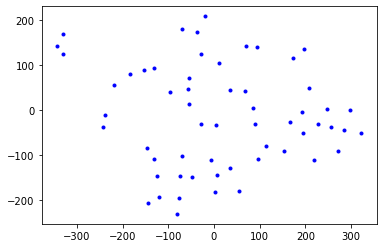

In [182]:
plt.plot(pc[:,0], pc[:,1], 'b.')